In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as lin
%matplotlib inline

# read data

## read Reguly 06 data

In [28]:
pd.read_csv('data/yeast/reguly06/LC_BIOCHEMICAL_011906_MinusRNA.txt',sep='\t', nrows = 1)


,Bait gene/protein,Hit gene/protein,Bait Standard Name,Hit Standard Name,Experimental System,Source,PubMed ID
0,YBR236C,YML010W,ABD1,SPT5,Affinity Capture-MS,Lindstrom DL et al,12556496


In [244]:
usecols = 'Bait gene/protein,Hit gene/protein'.split(',')
colnames = 'bait,hit'.split(',')
reguly = pd.read_csv('data/yeast/reguly06/LC_BIOCHEMICAL_011906_MinusRNA.txt',sep='\t', usecols = usecols,
                     dtype="str")
reguly = reguly.rename(columns={k : v for k,v in zip(usecols,colnames)})
display(reguly)
print(np.count_nonzero(reguly.duplicated()), 'duplicates')
print(len(reguly) - np.count_nonzero(reguly.duplicated()), 'unique')

,bait,hit
0,YBR236C,YML010W
1,YML010W,YBR236C
2,YDR448W,YPL254W
3,YDR448W,YDR176W
4,YDR448W,YOR257W
...,...,...
21130,YKL138C-A,YDR201W
21131,YKL138C-A,YKR083C
21132,YKL138C-A,YDR016C
21133,YKL138C-A,YBR233W-A


6966 duplicates
14169 unique


In [277]:
# sort bait, hit since we are only interested in undirected edges
# this will cause transposes to look like duplicates, which then get removed
pint = pd.DataFrame(np.sort(reguly,axis=1),columns=['a','b'])
display(pint)
duplicated = pint.duplicated()
print(np.count_nonzero(duplicated), 'duplicates')
pint = pint[~duplicated]
print(len(pint), 'unique')

,a,b
0,YBR236C,YML010W
1,YBR236C,YML010W
2,YDR448W,YPL254W
3,YDR176W,YDR448W
4,YDR448W,YOR257W
...,...,...
21130,YDR201W,YKL138C-A
21131,YKL138C-A,YKR083C
21132,YDR016C,YKL138C-A
21133,YBR233W-A,YKL138C-A


9277 duplicates
11858 unique


In [280]:
gene_names = list(set(pint['a'].append(pint['b']))) #find unique gene names
gene_names.sort()
n_genes = len(gene_names)
print(n_genes,'genes')
gene_name_hash = {k : v for k,v in zip(gene_names,range(len(gene_names)))}

3307 genes


In [296]:
import scipy.sparse as sparse
ai = pint.loc[:,'a'].apply(lambda x: gene_name_hash[x])
bi = pint.loc[:,'b'].apply(lambda x: gene_name_hash[x])
#define upper triangle of protein interaction matrix
pi_ut_coo = sparse.coo_matrix((np.ones(len(pint)),(ai,bi)),shape = (n_genes,n_genes))
#convert to csc for efficiency and flexibility
pi_csc = sparse.csc_matrix(pi_ut_coo)
#symmetrize csc matrix
rows, cols = pi_csc.nonzero()
pi_csc[cols, rows] = pi_csc[rows, cols]

/Users/kook/miniconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


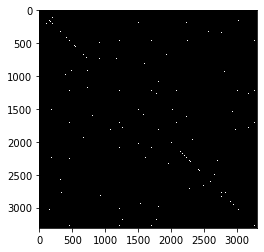

In [297]:
pi_dense = pi_csc.toarray()
plt.imshow(pi_dense,cmap='gray_r')

## read Costanzo 10 or 16 data

In [106]:
pd.read_csv('data/yeast/costanzo10.txt',sep='\t', nrows = 1)

,#BioGRID Interaction ID,Entrez Gene Interactor A,Entrez Gene Interactor B,BioGRID ID Interactor A,BioGRID ID Interactor B,Systematic Name Interactor A,Systematic Name Interactor B,Official Symbol Interactor A,Official Symbol Interactor B,Synonyms Interactor A,...,Pubmed ID,Organism Interactor A,Organism Interactor B,Throughput,Score,Modification,Phenotypes,Qualifications,Tags,Source Database
0,354378,851236,850395,31767,31012,YAL063C,YCR028C-A,FLO9,RIM1,flocculin FLO9|L000003331,...,20093466,559292,559292,High Throughput,-0.1969,-,colony size,A Synthetic Genetic Array (SGA) analysis was c...,-,BIOGRID


In [150]:
#usecols = 'Official Symbol Interactor A,Official Symbol Interactor B,Score'.split(',')
usecols = 'Systematic Name Interactor A,Systematic Name Interactor B,Score'.split(',')
names = {k : v for k,v in zip(usecols,'a,b,score'.split(','))}

costanzo = pd.read_csv('data/yeast/costanzo16.tab2.txt',
                 sep='\t', usecols = usecols,
                 dtype = {k : v for k,v in zip(usecols,[np.str,np.str,np.float])},
                na_values = ['-'])
costanzo = costanzo.rename(columns = names)
costanzo

,a,b,score
0,YAL001C,YDL126C,0.1745
1,YAL001C,YDL145C,0.1957
2,YAL001C,YDR238C,0.2682
3,YAL001C,YDR280W,0.2291
4,YAL001C,YDR292C,0.1834
...,...,...,...
326785,YPR201W,YOR140W,-0.1497
326786,YPR201W,YOR270C,-0.1228
326787,YPR201W,YPL101W,-0.1839
326788,YPR201W,YPL106C,-0.1640


In [151]:
duplicated = costanzo.drop('score',axis=1).duplicated()
print(np.count_nonzero(duplicated), 'duplicates')
costanzo_unique = costanzo[~duplicated]
print(len(costanzo_unique),'unique')

1156 duplicates
325634 unique


## assign indices to gene interaction network

In [164]:
def hashbrown(name):
    try:
        return gene_name_hash[name]
    except:
        return -1

In [331]:
gint = costanzo_unique[['a','b']].applymap(hashbrown).rename(columns={'a':'a_i','b':'b_i'})
gint['a'] = costanzo_unique['a']
gint['b'] = costanzo_unique['b']
gint['score'] = costanzo_unique['score']
gint = gint[np.logical_and(gint.a_i > -1,gint.b_i > -1) ]
display(gint)

gi_coo = sparse.coo_matrix((gint['score'],(gint['a_i'],gint['b_i'])))
gi_csc = sparse.csc_matrix(gi_coo)

assert(gi_csc.shape == pi_csc.shape)

,a_i,b_i,a,b,score
0,11,445,YAL001C,YDL126C,0.1745
1,11,459,YAL001C,YDL145C,0.1957
2,11,653,YAL001C,YDR238C,0.2682
3,11,669,YAL001C,YDR280W,0.2291
4,11,674,YAL001C,YDR292C,0.1834
...,...,...,...,...,...
326785,3306,2922,YPR201W,YOR140W,-0.1497
326786,3306,2995,YPR201W,YOR270C,-0.1228
326787,3306,3105,YPR201W,YPL101W,-0.1839
326788,3306,3107,YPR201W,YPL106C,-0.1640


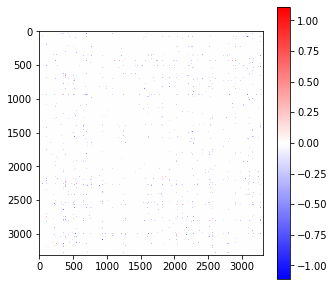

In [303]:
def bwr_plot(arr,**kwargs):
    vmax = np.max(np.abs(arr))
    plt.imshow(arr,vmax=vmax,vmin=-vmax,cmap='bwr')
plt.figure(figsize=(5,5))
bwr_plot(gi_csc.toarray());plt.colorbar()

# compute PI network properties

In [192]:
import scipy.sparse.linalg as slin

## eigenvector centrality

find the perron-frobenius eigenvector

84


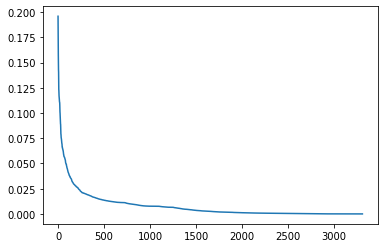

In [326]:
eigs, vecs = slin.eigsh(pi_csc,k=1)
pfeig, pfvec = eigs[0], vecs[:,0]
#clean up pfvec
pfvec[np.isclose(pfvec,0)] = 0

pfvec = pfvec/np.sign(pfvec.sum())
assert(not np.any(pfvec < 0)) #assert non-negativity of pfvec
print(np.count_nonzero(np.isclose(pfvec,0)))
plt.plot(np.sort(pfvec)[::-1])

# make samples, labels

In [346]:
thresh = 0;

samples = gint
samples['a_eigcent'] = pfvec[samples['a_i']]
samples['b_eigcent'] = pfvec[samples['b_i']]
samples['label'] = (samples['score']>0).astype(np.int)
display(samples)

,a_i,b_i,a,b,score,a_eigcent,b_eigcent,label
0,11,445,YAL001C,YDL126C,0.1745,0.000794,0.018736,1
1,11,459,YAL001C,YDL145C,0.1957,0.000794,0.001203,1
2,11,653,YAL001C,YDR238C,0.2682,0.000794,0.000393,1
3,11,669,YAL001C,YDR280W,0.2291,0.000794,0.025867,1
4,11,674,YAL001C,YDR292C,0.1834,0.000794,0.000512,1
...,...,...,...,...,...,...,...,...
326785,3306,2922,YPR201W,YOR140W,-0.1497,0.007668,0.007432,0
326786,3306,2995,YPR201W,YOR270C,-0.1228,0.007668,0.001131,0
326787,3306,3105,YPR201W,YPL101W,-0.1839,0.007668,0.018218,0
326788,3306,3107,YPR201W,YPL106C,-0.1640,0.007668,0.023984,0


In [342]:
samples[['a_eigcent','b_eigcent']].to_numpy().shape

(173469, 2)

# SVM

In [336]:
from sklearn import svm
model = svm.SVC()

In [ ]:
model.fit(samples[['a_eigcent','b_eigcent']].to_numpy(),
          samples['label'].to_numpy()
         )

# counting things

In [185]:
gi_sparse.shape

(3307, 3307)

In [186]:
pi_sparse.shape

(3306, 3307)

In [152]:
costanzo_genes = list(set(costanzo_unique['a'].append(costanzo_unique['b'])))

In [153]:
len(costanzo_genes)

5293

In [154]:
len(costanzo_genes)

5293

In [155]:
len(gene_names)

3307

In [156]:
len(set(costanzo_genes + gene_names))

5646

In [148]:
3885 + 3307 - 5061

2131

In [157]:
5293 + 3307 - 5646

2954

In [158]:
326790/(6000**2)

0.0090775